In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time
import warnings 

In [2]:
#input data
df = pd.read_csv("modified_duke.csv" , index_col=False)
print(df.shape)

(229, 1034)


In [3]:
#df.describe()

In [4]:
# data preprocessing 
# you could also do encoder function here. i choose do lambda function
df['Path_Response'] = df['Path_Response'].apply(lambda x : 0 if x == 2 else x )
df = df.set_index('Patient_ID')
#del df['Unnamed: 32']
print(df.shape)

(229, 1033)


In [5]:
print(df.groupby('Path_Response').size())

Path_Response
0    178
1     51
dtype: int64


In [6]:
# splitting into training and test sets for series
Y = df['Path_Response']
print(type(Y))
print(Y.shape)
X = df.drop(['Path_Response'] , axis = 1)
print(X.shape)

X_train , X_test , Y_train , Y_test  = train_test_split(X , Y , test_size = 0.2 , random_state = 15)

<class 'pandas.core.series.Series'>
(229,)
(229, 1032)


In [7]:
# Models for comparison
models_list = []
models_list.append(('CART', DecisionTreeClassifier()))
models_list.append(('SVM' , SVC()))
models_list.append(('NB' , GaussianNB()))
models_list.append(('KNN' , KNeighborsClassifier()))
models_list.append(('rf' , RandomForestClassifier()))

In [8]:
# Evaluation of model accuracy  using raw data
num_folds = 10
results = []
names = []

for name , model in models_list:
    kfold = KFold(n_splits = num_folds )
    start = time.time()
    cv_results = cross_val_score(model , X_train , Y_train , cv = kfold , scoring = 'accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f) (run time: %f)" %(name, cv_results.mean(), cv_results.std(), end-start))

CART: 0.637719 (0.138841) (run time: 0.858656)
SVM: 0.770468 (0.064450) (run time: 0.146499)
NB: 0.311696 (0.066384) (run time: 0.111788)
KNN: 0.748246 (0.062868) (run time: 0.227951)
rf: 0.759649 (0.055166) (run time: 2.064597)


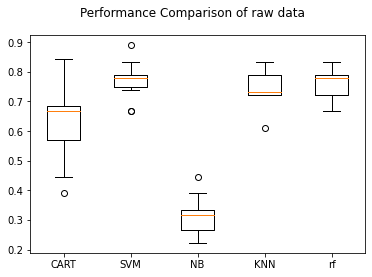

In [9]:
#plot the model accuracy
fig = plt.figure()
fig.suptitle('Performance Comparison of raw data')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [10]:
#Evaluation of algorithm on Standardised dataset

import warnings 
pipelines = []
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',
                                                                        DecisionTreeClassifier())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC( ))])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB',
                                                                      GaussianNB())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',
                                                                       KNeighborsClassifier())])))
pipelines.append(('Scaledrf', Pipeline([('Scaler', StandardScaler()),('rf',
                                                                       RandomForestClassifier())])))
results = []
names = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    kfold = KFold(n_splits = num_folds )
    for name , model in pipelines:
        start = time.time()
        cv_results = cross_val_score(model , X_train , Y_train , cv = kfold , scoring = 'accuracy')
        end = time.time()
        results.append(cv_results)
        names.append(name)
        print("%s: %f (%f) (run time: %f)" % (name , cv_results.mean() , cv_results.std() , end-start))


ScaledCART: 0.627778 (0.099750) (run time: 0.983461)
ScaledSVM: 0.770468 (0.064450) (run time: 0.240833)
ScaledNB: 0.421345 (0.101217) (run time: 0.178198)
ScaledKNN: 0.743567 (0.053085) (run time: 0.301906)
Scaledrf: 0.759357 (0.057015) (run time: 2.213838)


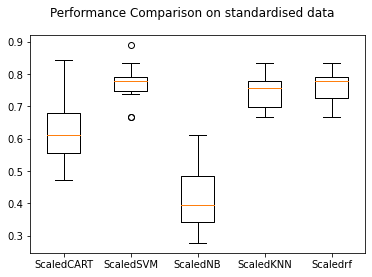

In [11]:
fig = plt.figure()
fig.suptitle('Performance Comparison on standardised data')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [12]:
print(" SVM seems to be better model")

 SVM seems to be better model


**Choosing SVM**

In [13]:
# Tuning SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1 , 0.3 , 0.5 , 0.7 , 0.9 , 1.0 , 1.3 , 1.5 , 1.7 , 2.0]
kernel_values = ['linear' , 'poly' , 'rbf' , 'sigmoid']
param_grid = dict(C = c_values , kernel = kernel_values)
model = SVC()
kfold = KFold(n_splits = num_folds)
grid = GridSearchCV(estimator = model , param_grid = param_grid , scoring = 'accuracy' , cv = kfold)
grid_result = grid.fit(rescaledX , Y_train)
print("Best : %f using %s" % (grid_result.best_score_ , grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best : 0.781287 using {'C': 1.7, 'kernel': 'poly'}
0.704094 (0.102287) with: {'C': 0.1, 'kernel': 'linear'}
0.753801 (0.071942) with: {'C': 0.1, 'kernel': 'poly'}
0.770468 (0.064450) with: {'C': 0.1, 'kernel': 'rbf'}
0.770468 (0.064450) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.692982 (0.100943) with: {'C': 0.3, 'kernel': 'linear'}
0.753801 (0.067515) with: {'C': 0.3, 'kernel': 'poly'}
0.770468 (0.064450) with: {'C': 0.3, 'kernel': 'rbf'}
0.770468 (0.064450) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.692982 (0.100943) with: {'C': 0.5, 'kernel': 'linear'}
0.759357 (0.062193) with: {'C': 0.5, 'kernel': 'poly'}
0.770468 (0.064450) with: {'C': 0.5, 'kernel': 'rbf'}
0.764912 (0.065958) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.692982 (0.100943) with: {'C': 0.7, 'kernel': 'linear'}
0.759357 (0.062193) with: {'C': 0.7, 'kernel': 'poly'}
0.770468 (0.064450) with: {'C': 0.7, 'kernel': 'rbf'}
0.770468 (0.064450) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.692982 (0.100943) with: {'C': 0.9, 'kernel': 'linea

In [14]:
print(" SVM 'c' = 2.0, kernal = 'poly' seems to be better parameter")

 SVM 'c' = 2.0, kernal = 'poly' seems to be better parameter


In [15]:
# Fit the  model
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
model = SVC(C=2.0, kernel='poly')
start = time.time()
model.fit(X_train_scaled, Y_train)
end = time.time()
print( "Run Time: %f" % (end-start))

Run Time: 0.008220


In [16]:
# Estimate accuracy on test dataset
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_test_scaled = scaler.transform(X_test)
predictions = model.predict(X_test_scaled)

In [17]:
print("Accuracy score %f" % accuracy_score(Y_test, predictions))
print(classification_report(Y_test, predictions))


Accuracy score 0.804348
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        37
           1       0.00      0.00      0.00         9

    accuracy                           0.80        46
   macro avg       0.40      0.50      0.45        46
weighted avg       0.65      0.80      0.72        46



/Users/sasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
print(confusion_matrix(Y_test, predictions))

[[37  0]
 [ 9  0]]


In [19]:
Act_vs_pred = pd.DataFrame({"Actual": Y_test, "Predictions": model.predict(X_test_scaled)})
Act_vs_pred.head(10)

,Actual,Predictions
Patient_ID,,
Breast_MRI_687,0,0
Breast_MRI_539,1,0
Breast_MRI_884,0,0
Breast_MRI_672,0,0
Breast_MRI_751,0,0
Breast_MRI_397,0,0
Breast_MRI_757,0,0
Breast_MRI_517,0,0
Breast_MRI_857,0,0


**Another approach**

**Feature selection and then fit the model**

**Select best features from Lasso and build model**

In [20]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [21]:
# scale the features
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [22]:
#  linear regression object from sklearn does not allow for regularisation. So for a regularised 
#linear regression you need to import specifically "Lasso"
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=10))
sel_.fit(scaler.transform(X_train), Y_train)

/Users/sasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.477e-01, tolerance: 3.236e-03
  model = cd_fast.enet_coordinate_descent(


SelectFromModel(estimator=Lasso(alpha=0.001, random_state=10))

In [23]:
sel_.get_support()

array([False, False, False, ..., False, False, False])

In [24]:
# make a list with the selected features and print the outputs
selected_feat = X.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 1032
selected features: 181
features with coefficients shrank to zero: 851


In [25]:
# remove the features from the training and testing set

X_train_selected = sel_.transform(scaler.transform(X_train))
X_test_selected = sel_.transform(scaler.transform(X_test))

X_train_selected.shape, X_test_selected.shape

((183, 181), (46, 181))

In [26]:
X_train.shape, X_test.shape

((183, 1032), (46, 1032))

In [27]:
# Evaluation of model accuracy  using selected features 

num_folds = 10
results = []
names = []

for name , model in models_list:
    kfold = KFold(n_splits = num_folds )
    start = time.time()
    cv_results = cross_val_score(model , X_train_selected , Y_train , cv = kfold , scoring = 'accuracy')
    end = time.time()
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f) (run time: %f)" %(name, cv_results.mean(), cv_results.std(), end-start))

CART: 0.688889 (0.083497) (run time: 0.138682)
SVM: 0.770468 (0.064450) (run time: 0.038769)
NB: 0.661988 (0.112230) (run time: 0.009699)
KNN: 0.748538 (0.066574) (run time: 0.136817)
rf: 0.759942 (0.059830) (run time: 1.321689)


In [28]:
# Tuning SVM
c_values = [0.1 , 0.3 , 0.5 , 0.7 , 0.9 , 1.0 , 1.3 , 1.5 , 1.7 , 2.0]
kernel_values = ['linear' , 'poly' , 'rbf' , 'sigmoid']
param_grid = dict(C = c_values , kernel = kernel_values)
model = SVC()
kfold = KFold(n_splits = num_folds)
grid = GridSearchCV(estimator = model , param_grid = param_grid , scoring = 'accuracy' , cv = kfold)
grid_result = grid.fit(X_train_selected, Y_train)
print("Best : %f using %s" % (grid_result.best_score_ , grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best : 0.829532 using {'C': 0.5, 'kernel': 'linear'}
0.775439 (0.120444) with: {'C': 0.1, 'kernel': 'linear'}
0.764912 (0.065958) with: {'C': 0.1, 'kernel': 'poly'}
0.770468 (0.064450) with: {'C': 0.1, 'kernel': 'rbf'}
0.770468 (0.064450) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.813743 (0.078991) with: {'C': 0.3, 'kernel': 'linear'}
0.759357 (0.062193) with: {'C': 0.3, 'kernel': 'poly'}
0.770468 (0.064450) with: {'C': 0.3, 'kernel': 'rbf'}
0.770468 (0.064450) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.829532 (0.100926) with: {'C': 0.5, 'kernel': 'linear'}
0.764912 (0.055820) with: {'C': 0.5, 'kernel': 'poly'}
0.770468 (0.064450) with: {'C': 0.5, 'kernel': 'rbf'}
0.770468 (0.064450) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.818421 (0.096752) with: {'C': 0.7, 'kernel': 'linear'}
0.764912 (0.055820) with: {'C': 0.7, 'kernel': 'poly'}
0.770468 (0.064450) with: {'C': 0.7, 'kernel': 'rbf'}
0.770468 (0.064450) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.818421 (0.096752) with: {'C': 0.9, 'kernel': 'lin

In [29]:
print(" SVM 'c' = 2.0, kernal = 'linear' seems to be better parameter")

 SVM 'c' = 2.0, kernal = 'linear' seems to be better parameter


In [30]:
# Fit the  model
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
model = SVC(C=2.0, kernel='poly')
start = time.time()
model.fit(X_train_selected, Y_train)
end = time.time()
print( "Run Time: %f" % (end-start))

Run Time: 0.003990


In [31]:
# Estimate accuracy on test dataset
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
predictions = model.predict(X_test_selected)

In [32]:
print("Accuracy score %f" % accuracy_score(Y_test, predictions))
print(classification_report(Y_test, predictions))

Accuracy score 0.804348
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        37
           1       0.00      0.00      0.00         9

    accuracy                           0.80        46
   macro avg       0.40      0.50      0.45        46
weighted avg       0.65      0.80      0.72        46



/Users/sasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
print(confusion_matrix(Y_test, predictions))

[[37  0]
 [ 9  0]]


In [34]:
Act_vs_pred = pd.DataFrame({"Actual": Y_test, "Predictions": model.predict(X_test_selected)})
Act_vs_pred.head(10)

,Actual,Predictions
Patient_ID,,
Breast_MRI_687,0,0
Breast_MRI_539,1,0
Breast_MRI_884,0,0
Breast_MRI_672,0,0
Breast_MRI_751,0,0
Breast_MRI_397,0,0
Breast_MRI_757,0,0
Breast_MRI_517,0,0
Breast_MRI_857,0,0


**END**